<a href="https://colab.research.google.com/github/roncala/Final_project/blob/main/Baseline_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
import os, random, shutil
import matplotlib.pyplot as plt
from collections import Counter
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from torch.utils.data import Subset, DataLoader
import numpy as np
import torch
from torch.utils.data import WeightedRandomSampler, DataLoader

# 1) Paths
from google.colab import drive
drive.mount('/content/drive')

# 1) Base path in your Drive
base_dir   = "/content/drive/MyDrive/Dataset/archive"
orig_train  = os.path.join(base_dir, "train")
orig_test   = os.path.join(base_dir, "test")

#Stage 10% sample on the VM
sample_ratio = 0.1
tmp_root="/content/tmp/fer2013_sample"
tmp_train = os.path.join(tmp_root, "train")
tmp_test = os.path.join(tmp_root, "test")

if os.path.exists(tmp_root):
    shutil.rmtree(tmp_root)

#Copy 10% of each class-subfolder into tmp
for src_dir, dst_dir in [(orig_train, tmp_train), (orig_test, tmp_test)]:
  os.makedirs(dst_dir, exist_ok=True)
  for label in os.listdir(src_dir):
    src_label = os.path.join(src_dir, label)
    if not os.path.isdir(src_label):
      continue
    dst_label = os.path.join(dst_dir, label)
    os.makedirs(dst_label, exist_ok=True)

    all_files = [f for f in os.listdir(src_label) if os.path.isfile(os.path.join(src_label, f))]
    k = max(1, int(len(all_files) * sample_ratio))
    sample_files = random.sample(all_files, k)

    for fname in sample_files:
      shutil.copy(os.path.join(src_label, fname), os.path.join(dst_label, fname))

  print(f"Copied 10% of '{src_dir}' -> '{dst_dir}'" )

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Copied 10% of '/content/drive/MyDrive/Dataset/archive/train' -> '/content/tmp/fer2013_sample/train'
Copied 10% of '/content/drive/MyDrive/Dataset/archive/test' -> '/content/tmp/fer2013_sample/test'


In [9]:
import os, random, shutil
import matplotlib.pyplot as plt
from collections import Counter
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from torch.utils.data import Subset, DataLoader
import numpy as np
import torch
from torch.utils.data import WeightedRandomSampler, DataLoader


transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # ensure single-channel
    transforms.ToTensor(),                        # PIL→[0,1] FloatTensor C×H×W
])

train_dataset = ImageFolder(tmp_train, transform=transform)
test_dataset  = ImageFolder(tmp_test, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
test_loader  = DataLoader(test_dataset,  batch_size=32, shuffle=False, num_workers=2)

print(f"Loaded {len(train_dataset)} train images")
print(f"Loaded {len(test_dataset)}  test images")

Loaded 2870 train images
Loaded 715  test images


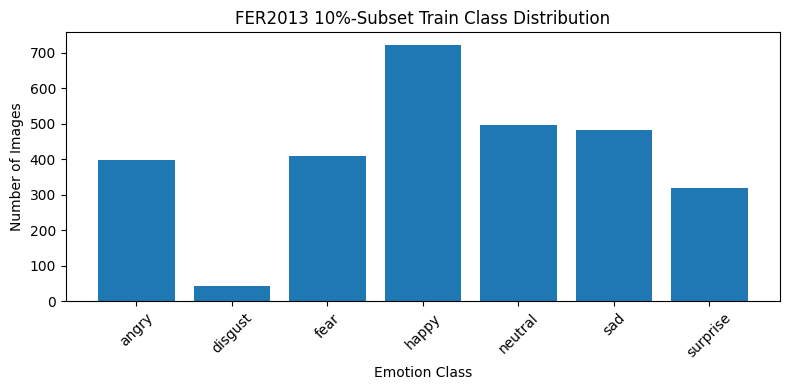

In [10]:
#Visualize class distribution in the TRAIN set
from collections import Counter
import matplotlib.pyplot as plt

train_counts = Counter(train_dataset.targets)
classes = train_dataset.classes

counts = [train_counts[i] for i in range(len(classes))]

plt.figure(figsize=(8,4))
plt.bar(classes, counts)
plt.xlabel("Emotion Class")
plt.ylabel("Number of Images")
plt.title("FER2013 10%‐Subset Train Class Distribution")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
plt.savefig('FER2013_Class_Distribution.pdf')

In [11]:
from torchvision import transforms

# For baseline CNN on 48×48:
base_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # ensure single-channel
    transforms.ToTensor(),                       # [0,255]→[0.0,1.0]
])

# For transfer learning
tl_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # replicate into 3 channels
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                         std =[0.229,0.224,0.225]),
])

In [12]:
import torch.nn as nn

class BaselineCNN(nn.Module):
    def __init__(self, num_classes=7):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),                # 48→24
            nn.Conv2d(32,64,3,padding=1),   nn.ReLU(),
            nn.MaxPool2d(2),                # 24→12
            nn.Flatten()
        )
        self.classifier = nn.Sequential(
            nn.Linear(64*12*12, 128), nn.ReLU(), nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        return self.classifier(x)

In [13]:
import torch
from torch.optim import Adam
from sklearn.metrics import classification_report

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model  = BaselineCNN(num_classes=7).to(device)
opt    = Adam(model.parameters(), lr=1e-3)
loss_fn= nn.CrossEntropyLoss()

# train for 20 epochs
for epoch in range(20):
    model.train()
    running_loss = 0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        opt.zero_grad()
        logits = model(imgs)
        loss   = loss_fn(logits, labels)
        loss.backward()
        opt.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1} — loss: {running_loss/len(train_loader):.4f}")

# evaluate
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        preds = model(imgs).argmax(dim=1).cpu()
        all_preds.extend(preds.numpy())
        all_labels.extend(labels.numpy())

print("\nBaseline CNN Classification Report:")
print(classification_report(all_labels, all_preds,
      target_names=classes))

Epoch 1 — loss: 1.8392
Epoch 2 — loss: 1.7908
Epoch 3 — loss: 1.7684
Epoch 4 — loss: 1.7444
Epoch 5 — loss: 1.6772
Epoch 6 — loss: 1.6541
Epoch 7 — loss: 1.6229
Epoch 8 — loss: 1.6143
Epoch 9 — loss: 1.5921
Epoch 10 — loss: 1.5549
Epoch 11 — loss: 1.5326
Epoch 12 — loss: 1.5061
Epoch 13 — loss: 1.4860
Epoch 14 — loss: 1.4615
Epoch 15 — loss: 1.4321
Epoch 16 — loss: 1.4047
Epoch 17 — loss: 1.3650
Epoch 18 — loss: 1.3371
Epoch 19 — loss: 1.2846
Epoch 20 — loss: 1.2517

Baseline CNN Classification Report:
              precision    recall  f1-score   support

       angry       0.36      0.14      0.20        95
     disgust       0.00      0.00      0.00        11
        fear       0.18      0.17      0.17       102
       happy       0.50      0.67      0.57       177
     neutral       0.29      0.29      0.29       123
         sad       0.34      0.29      0.31       124
    surprise       0.44      0.63      0.52        83

    accuracy                           0.38       715
   m

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))




```
Next Steps

Transfer Learning
Fine-tuning a pretrained network (e.g. ResNet50, MobileNetV2) should give a stronger feature extractor out of the box.
Address Class Imbalance
Oversample small classes or generate synthetic examples (e.g. via augmentation).
Use a class-weighted loss or focal loss to penalize mistakes on rare classes more heavily.
Data Augmentation
Experiment with deeper or wider CNNs if compute allows.
```

